<a href="https://colab.research.google.com/github/ushham/GISTools/blob/main/Shapefile_points_to_line_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install podpac
!pip install botocore
!pip install boto3
!pip install rasterio
!pip install s3fs
!pip install pyshp

In [ ]:
from podpac.datalib.terraintiles import TerrainTiles
from podpac import Coordinates, clinspace
import podpac
import numpy as np
import pandas as pd
import os
import shapefile as shp
import geopy.distance as dist

Function to find elevation using Podpac library


In [ ]:
def elevation(lat, lon):
  node = TerrainTiles(zoom=14)
  c = Coordinates([lat, lon], dims=['lat', 'lon'])

  o = node.eval(c)
  return float(o)

Open all shapefiles in given folder and find elevation given lat and lon

In [ ]:
#Find shapefiles in given folder
folderin = ''
folderout = folderin + '/Elevation'

loncol = 2
latcol = 2

files = os.listdir(folderin)

#run through each file
for f in files:
  fi = folderin + '/' + f
  of = folderout + '/' + f
  print(fi)
  #check the file is a shapefile
  if os.path.splitext(fi)[1] == '.shp':
    #Make reader and writer shapefile objects
    r = shp.Reader(fi)
    w = shp.Writer(of)

    fields = list(r.fields)
    w.fields = fields

    #create new feild in writer to store elevation data
    w.field('Elevation', 'N', decimal=6)

    #pass data to elevation function
    i = 0
    for shaperec in r.iterShapeRecords():
      data = [*shaperec.record]
      lat, lon = data[latcol], data[loncol] #lat and lon columns
      ele = elevation(lat, lon)
      shaperec.record.append(ele)
      w.record(*shaperec.record)
      w.shape(shaperec.shape)

    w.close()
    r.close()

Convert the pointshape file into a line shapefile, exporting records on elevation, distance, and gradient of each line

In [ ]:
#Find shapefiles in given folder
folderin = ''
folderout = folderin + '/Line'

#column positions
datecol = 1
loncol = 2
latcol = 2
elecol = 4

files = os.listdir(folderin)

files = [f for f in files if not ('Camping' in f)]
print(files)
#run through each file
for f in files:
  fi = folderin + '/' + f
  of = folderout + '/' + f

  #check the file is a shapefile
  if os.path.splitext(fi)[1] == '.shp':
    print(fi)
    #Make reader and writer shapefile objects
    r = shp.Reader(fi)
    w = shp.Writer(of, shp.POLYLINE) #polyline shapetype

    w.field('Date')
    w.field('StartEle', 'N', decimal=6) 
    w.field('EndEle', 'N', decimal=6) 
    w.field('Dist', 'N', decimal=6) 
    w.field('Gradient', 'N', decimal=6) 

    #list out all points
    coords = []
    i = 0
    for shaperec in r.iterShapeRecords():
      rec = [] 
      data = [*shaperec.record]
      if i > 0:
        #Create Line using starting lon, lat -> end lon lat
        coords = [[prevdata[loncol], prevdata[latcol]], [data[loncol], data[latcol]]]
        w.line([coords])

        #create data record
        d = dist.vincenty((prevdata[latcol], prevdata[loncol]), (data[latcol], data[loncol])).km * 1000
        g = (data[elecol] - prevdata[elecol]) / d if d != 0 else 0
        rec = [data[datecol], prevdata[elecol], data[elecol], d, g]
        w.record(*rec)

      i += 1
      prevdata = data


    w.close()
    r.close()


Open all shapefiles in folder and extract date, distance, and elevation between each point for graphing altitude

In [ ]:
import reverse_geocoder 

#Find shapefiles in given folder
folderin = ''

files = sorted(os.listdir(folderin))
holder = []
cdist = 0       #cumulative distance holder

idcol = 0 
datecol = 1       #Date column
elecol = 4      #elevation column
latcol = 3
loncol = 2

files = [f for f in files if not ('Camping' in f)]

def country(lat, lon):
  coordinates = (lat, lon)
  x = reverse_geocoder.search(coordinates)
  return x[0]['cc']

prevdata = ''
#run through each file
for f in files:
  fi = folderin + '/' + f

  #check the file is a shapefile
  if os.path.splitext(fi)[1] == '.shp':
    print(fi)
    #Make reader and writer shapefile objects
    r = shp.Reader(fi)
    for shaperec in r.iterShapeRecords():
      data = [*shaperec.record]

      #find distance
      if prevdata == '':
        d = np.nan
        g = np.nan
      else:
        d = dist.vincenty((prevdata[latcol], prevdata[loncol]), (data[latcol], data[loncol])).km * 1000
        g = (data[elecol] - prevdata[elecol]) / d if d > 0 else 0
        cdist += d
      
      ctry = country(data[latcol], data[loncol])

      line = [data[idcol], data[datecol], data[latcol], data[loncol], cdist, d, data[elecol], g, ctry]
      holder.append(line)

      prevdata = data

dfData = pd.DataFrame(holder, columns=['ID', 'Date', 'Lat', 'Lon', 'CulmDist', 'Dist', 'Ele', 'Gradient', 'Country'])
dfData.to_csv(folderin + '/ElevationData.csv', index=False)


Converts distance and elevation csv into elevation plot

[]

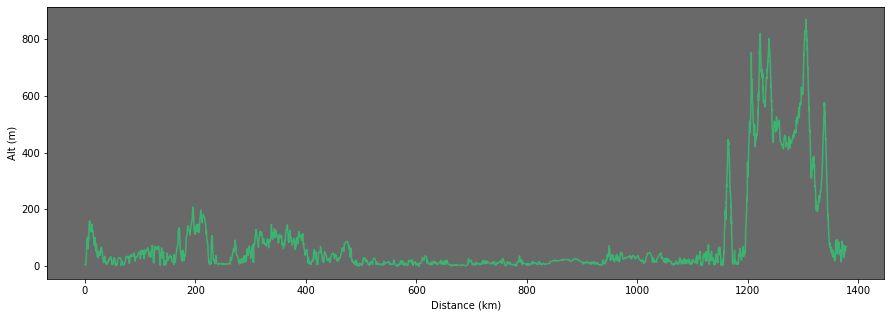

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('')

fig, ax = plt.subplots(figsize=(15, 5))

#Convert distance from km to m
ax.plot(df['CulmDist']/1000, df['Ele'], color='mediumseagreen')

ax.set_facecolor('dimgrey')
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Alt (m)')
plt.plot()
